In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm
import itertools

import warnings
warnings.filterwarnings("ignore")

## Step 1: Load the Data. Do initial analysis

In [750]:
df = pd.DataFrame()
for i in range(1,11):
    home_no = 'Home'+str(i)
    df[home_no] = pd.read_csv('./'+home_no+'_yr1.csv', header=None).squeeze()
df.index = pd.date_range('12/1/2014 00:15:00', periods=96*365, freq='15Min')
df.head()

,Home1,Home2,Home3,Home4,Home5,Home6,Home7,Home8,Home9,Home10
2014-12-01 00:15:00,0.65018,1.52690,2.45820,1.86970,2.01290,1.2184,3.9119,4.50310,1.66450,1.11030
2014-12-01 00:30:00,1.45400,0.52416,1.56750,1.96220,0.98391,1.2182,4.6354,2.95780,0.56778,1.61900
2014-12-01 00:45:00,0.72971,1.26470,1.11190,0.80571,1.76970,1.6335,2.1236,0.62704,2.63520,1.91270
2014-12-01 01:00:00,3.10750,1.41940,2.49390,1.79050,0.57814,0.4642,1.0696,0.24725,0.71595,0.59879
2014-12-01 01:15:00,0.63572,0.63155,0.69972,0.73211,2.00880,1.4907,2.1964,0.71342,0.39994,2.94840


In [751]:
df.describe()

,Home1,Home2,Home3,Home4,Home5,Home6,Home7,Home8,Home9,Home10
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,1.327208,1.524932,1.320148,1.267085,1.410759,1.112021,1.727100,1.544420,0.963147,1.135874
std,1.399019,1.445887,1.330075,1.211601,1.501369,1.332309,1.416806,1.614830,1.021310,1.262342
min,0.015124,0.009309,0.014889,0.000166,0.011386,0.028611,0.000409,0.012428,0.014082,0.013014
25%,0.315678,0.496020,0.230592,0.280095,0.199057,0.152625,0.436148,0.188740,0.164722,0.130815
50%,0.722875,0.947970,0.879725,0.839670,0.961815,0.560455,1.435350,1.040250,0.560455,0.513215
75%,1.988425,2.285975,2.041450,1.901425,2.133750,1.665725,2.695300,2.394875,1.506475,1.892125
max,15.500000,10.453000,9.738000,9.882000,12.246000,9.208000,11.891000,11.062000,8.736300,9.056800


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6B74E6D30>,
      dtype=object)

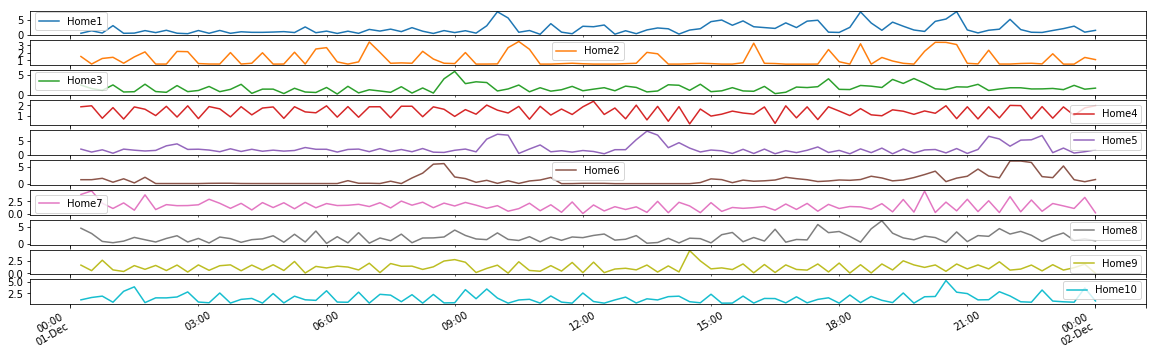

In [752]:
# Plot all homes' first day consumption
rcParams['figure.figsize'] = 20, 6
df.iloc[:96,:].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6B74E99B0>,
      dtype=object)

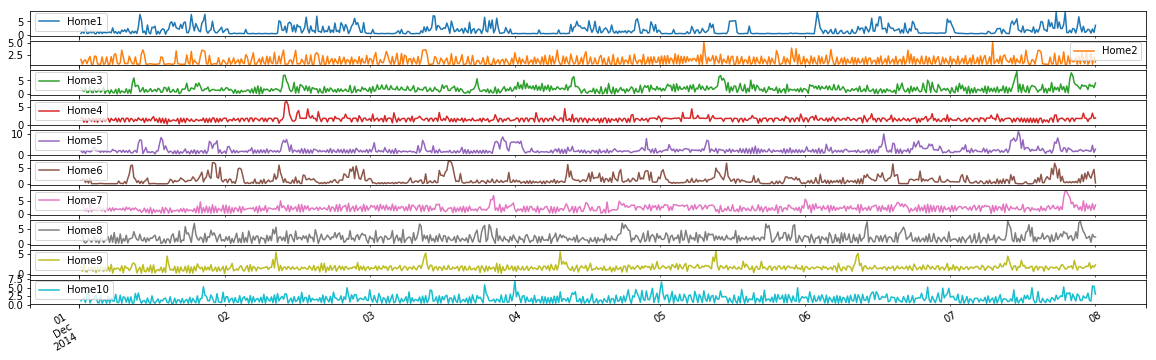

In [753]:
#Plot one week:
df[:96*7].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6BC51BFD0>,
      dtype=object)

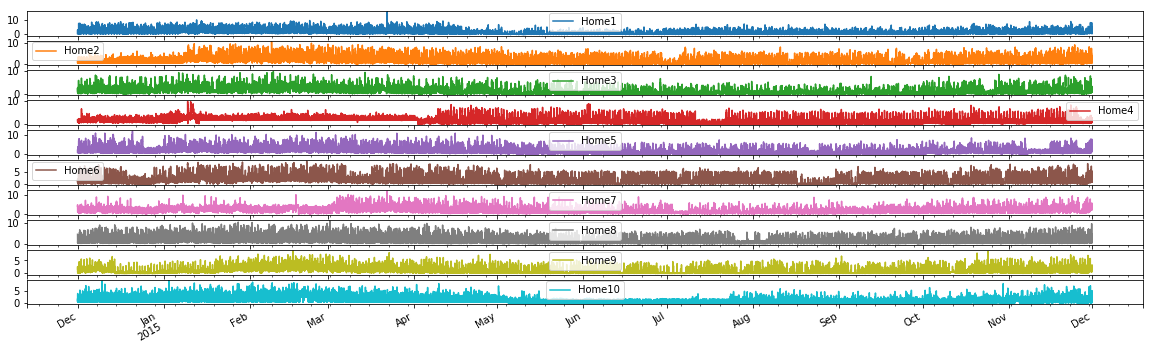

In [754]:
# Plot all data
df.plot(subplots=True)

## Step 2: Select Home no. to train on : iterate the whole process for each home.

In [802]:
input_home_no = input("Enter home no. for prediction: ")
home = 'Home'+input_home_no
input_home_no = int(input_home_no)
data = pd.DataFrame(df[home])
data.describe()

Enter home no. for prediction: 1


,Home1
count,35040.000000
mean,1.327208
std,1.399019
min,0.015124
25%,0.315678
50%,0.722875
75%,1.988425
max,15.500000


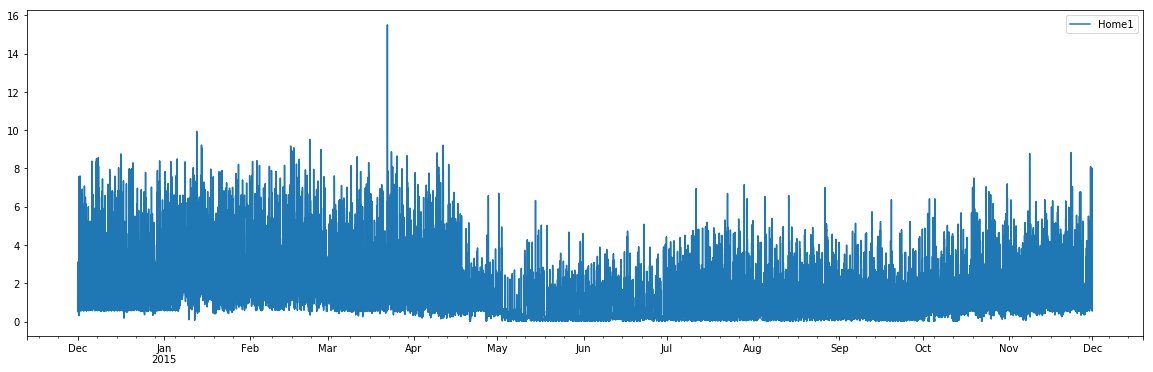

In [756]:
#Plot whole year:
data.plot()

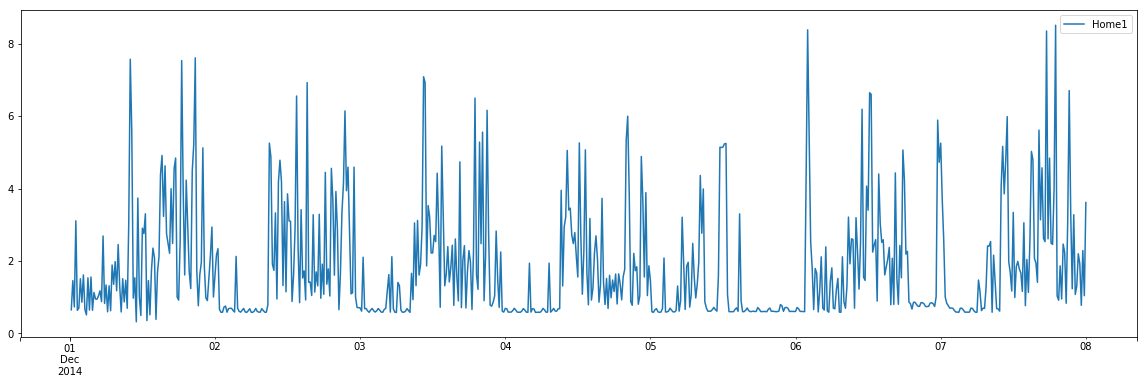

In [564]:
#Plot one week:
data[:96*7].plot()

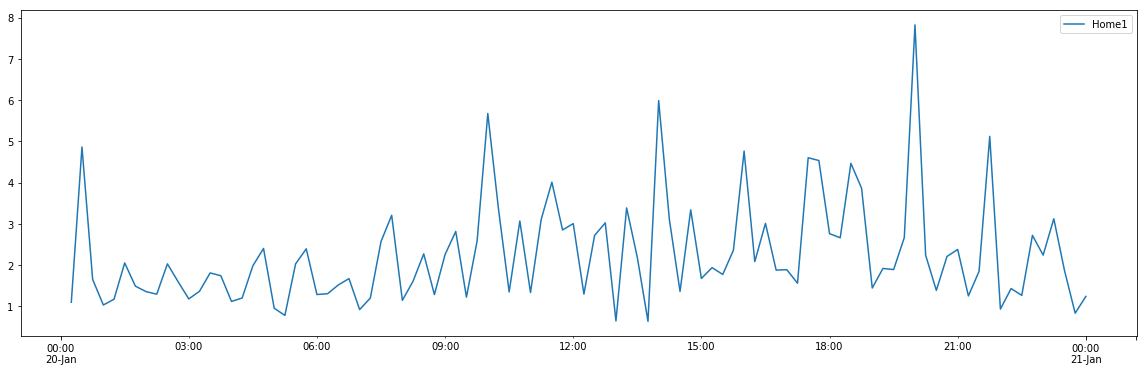

In [565]:
#Plot a random day:
randomday = 50
data[96*randomday:96*(randomday+1)].plot()

## Step 3: Features Extraction

#### 3.1: Basic Features - Clearly, the power consumption varies with time of the day, and month and day of the year. So these are basic features.

In [803]:
data['Month'] = df.index.month
data['Day'] = df.index.day
data['Hour'] = df.index.hour
data['Minute'] = df.index.minute
data.head()

,Home1,Month,Day,Hour,Minute
2014-12-01 00:15:00,0.65018,12,1,0,15
2014-12-01 00:30:00,1.45400,12,1,0,30
2014-12-01 00:45:00,0.72971,12,1,0,45
2014-12-01 01:00:00,3.10750,12,1,1,0
2014-12-01 01:15:00,0.63572,12,1,1,15


#### 3.2: Seasons - Power consumption also varies with seasons. Segregate the year into 4 seasons: Fall (August-November), Winter(December-February), Spring(March-April) and Summer (May-July).

In [804]:
#month_season_map = {8:1, 9:1, 10:1, 11:1, 12:2, 1:2, 2:2, 3:3, 4:3, 5:4, 6:4, 7:4}
#data['Season'] = data['Month'].map(month_season_map)
data['Fall']   = data['Month'].map(lambda x: x in [1,2,3])
data['Winter'] = data['Month'].map(lambda x: x in [4,5,6])
data['Spring'] = data['Month'].map(lambda x: x in [7,8,9])
data['Summer'] = data['Month'].map(lambda x: x in [10,11,12])
# Check random seasons
#data.loc['2014-12-22-15:30']['Season'] #22nd Dec is Winter-Solstice (Season: 2)
#data.loc['2015-03-23-15:30']['Season'] #23rd March is Spring-Equinox (Season: 3)
#data.loc['2015-06-21-15:30']['Season'] #21st June is Summer-Solstice (Season: 4)
#data.loc['2015-09-23-15:30']['Season'] #23rd September is Autumn-Equinox (Season: 1)
data.loc['2014-12-22-15:30'] #22nd Dec is Winter-Solstice (Season: 2)
data.loc['2015-03-23-15:30'] #23rd March is Spring-Equinox (Season: 3)
data.loc['2015-06-21-15:30'] #21st June is Summer-Solstice (Season: 4)
data.loc['2015-09-23-15:30'] #23rd September is Autumn-Equinox (Season: 1)

Home1     0.14219
Month           9
Day            23
Hour           15
Minute         30
Fall        False
Winter      False
Spring       True
Summer      False
Name: 2015-09-23 15:30:00, dtype: object

#### 3.3: Weekends and Peak-hours - Weekends have different power-consumption patterns in general. Peak-hours have high consumption.

In [805]:
data['Day_of_week'] = data.index.dayofweek
data.loc['2014-12-05-15-30']
data['is_weekend'] = data['Day_of_week'].map(lambda x: x in [5,6])
data.loc['2014-12-08-15-30']

,Home1,Month,Day,Hour,Minute,Fall,Winter,Spring,Summer,Day_of_week,is_weekend
2014-12-08 15:00:00,3.3756,12,8,15,0,False,False,False,True,0,False
2014-12-08 15:15:00,3.1249,12,8,15,15,False,False,False,True,0,False
2014-12-08 15:30:00,1.2998,12,8,15,30,False,False,False,True,0,False
2014-12-08 15:45:00,2.4269,12,8,15,45,False,False,False,True,0,False


In [806]:
peak_hours = [0,1,2, 8,9,10,11,12,13,14,15, 20,21,22,23] #Found from trend of above plot
data['Peak_hour'] = data['Hour'].map(lambda x: x in peak_hours)
#data.head()
data.head(96)['Peak_hour']

2014-12-01 00:15:00     True
2014-12-01 00:30:00     True
2014-12-01 00:45:00     True
2014-12-01 01:00:00     True
2014-12-01 01:15:00     True
2014-12-01 01:30:00     True
2014-12-01 01:45:00     True
2014-12-01 02:00:00     True
2014-12-01 02:15:00     True
2014-12-01 02:30:00     True
2014-12-01 02:45:00     True
2014-12-01 03:00:00    False
2014-12-01 03:15:00    False
2014-12-01 03:30:00    False
2014-12-01 03:45:00    False
2014-12-01 04:00:00    False
2014-12-01 04:15:00    False
2014-12-01 04:30:00    False
2014-12-01 04:45:00    False
2014-12-01 05:00:00    False
2014-12-01 05:15:00    False
2014-12-01 05:30:00    False
2014-12-01 05:45:00    False
2014-12-01 06:00:00    False
2014-12-01 06:15:00    False
2014-12-01 06:30:00    False
2014-12-01 06:45:00    False
2014-12-01 07:00:00    False
2014-12-01 07:15:00    False
2014-12-01 07:30:00    False
                       ...  
2014-12-01 16:45:00    False
2014-12-01 17:00:00    False
2014-12-01 17:15:00    False
2014-12-01 17:

## Step 4: Prepare Training and Cross-Validation datasets

### 4.1: Get the particular timeslot as input for prediction

In [761]:
date_entry = input('Enter the timeslot in YYYY-MM-DD-HH-MM format: ')
year, month, day, hour, minute = map(int, date_entry.split('-'))
pred_timeslot = datetime(year, month, day, hour, minute)
print(pred_timeslot)

Enter the timeslot in YYYY-MM-DD-HH-MM format: 2015-08-27-10-45
2015-08-27 10:45:00


### 4.2: Set training data as history till this timeslot (inclusive); Cross-validation as next 96 slots

In [807]:
#x_train = data.loc[:pred_timeslot][['Month','Day','Hour','Minute','Season','Day_of_week','is_weekend','Peak_hour']]
prev_timeslot = pred_timeslot - timedelta(minutes=15)
x_train = data.loc[:prev_timeslot][['Month','Day','Hour','Minute','Day_of_week','is_weekend','Peak_hour','Fall','Winter','Spring','Summer']]
y_train = data.loc[:prev_timeslot][[home]]
end_of_next_day = pred_timeslot + timedelta(days=1) - timedelta(minutes=15)
#x_cv = data.loc[next_timeslot:end_of_next_day][['Month','Day','Hour','Minute','Season','Day_of_week','is_weekend','Peak_hour']]
x_cv = data.loc[pred_timeslot:end_of_next_day][['Month','Day','Hour','Minute','Day_of_week','is_weekend','Peak_hour','Fall','Winter','Spring','Summer']]
y_cv = data.loc[pred_timeslot:end_of_next_day][[home]]

## Step 5: Train and Validate MAE errors for Basic Models

In [808]:
def train_model(model_name):
    if model_name == 'Linear Regression':
        model = linear_model.LinearRegression()
    elif model_name == 'KNN Regression':
        model = KNeighborsRegressor(n_neighbors=90)
    elif model_name == 'Random Forest':
        model = RandomForestRegressor(max_depth=20, random_state=0)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_cv)
    print("Mean Absolute Error using Linear Regression: %.9f kW" %mean_absolute_error(y_cv,y_pred))

In [764]:
def plot_y_comparisons():
    y_comparisons = pd.DataFrame({'Predicted':y_pred[:,0]}, index=y_cv.index)
    y_comparisons['Actual'] = y_cv
    plt.plot(y_comparisons.index, y_comparisons['Actual'], label="Actual")
    plt.plot(y_comparisons.index, y_comparisons['Predicted'], label="Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.show()

### 5.1: Linear Regression

Mean Absolute Error using Linear Regression: 0.378587093 kW


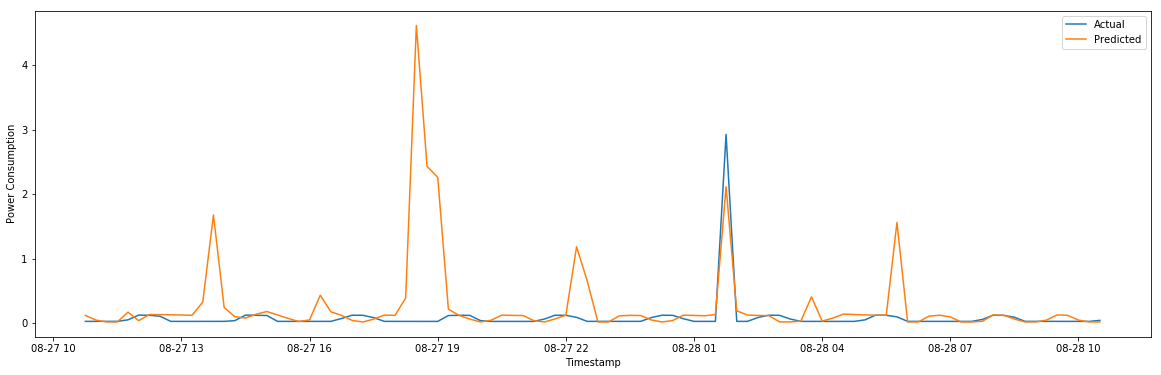

In [801]:
train_model("Linear Regression")
plot_y_comparisons()

### 5.2: K Nearest Neighbors Regression

Mean Absolute Error using Linear Regression: 0.363503397 kW


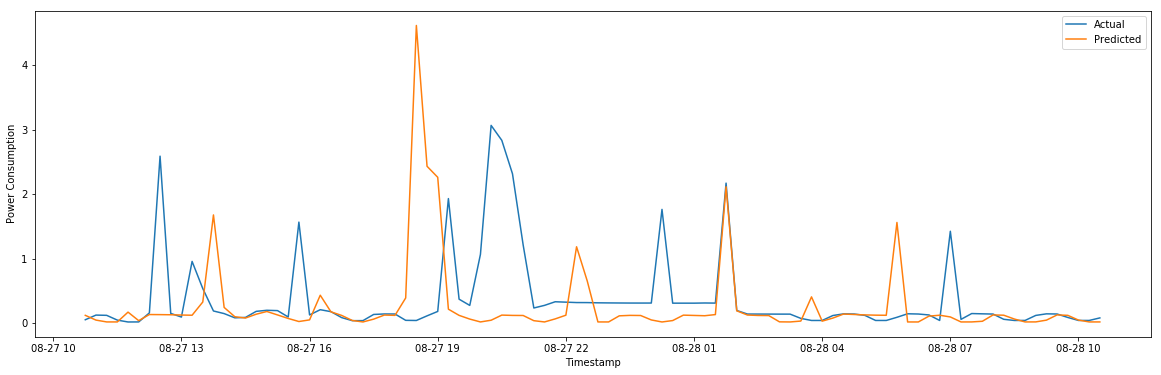

In [749]:
train_model("KNN Regression")
plot_y_comparisons()

### 5.3: Random Forest

Mean Absolute Error using Linear Regression: 1.764305999 kW


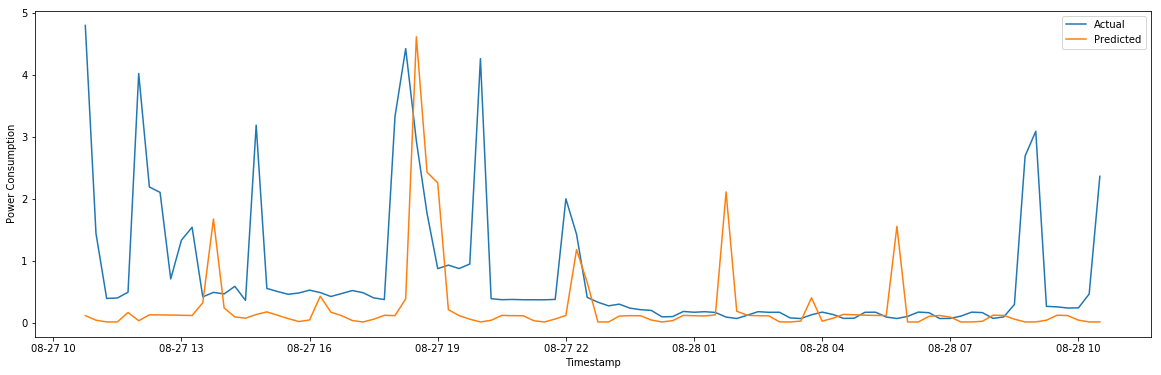

In [809]:
train_model("Random Forest")
plot_y_comparisons()

## Step 6: Train Seasonal ARIMA model and get MAE

### 6.1: Permute p,q and d values

In [589]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### 6.2: Get Optimum p,d,q values - using Grid Search

In [650]:
# Drop all feature columns
data = data[[home]]
data.head()

,Home10
2014-12-01 00:15:00,1.11030
2014-12-01 00:30:00,1.61900
2014-12-01 00:45:00,1.91270
2014-12-01 01:00:00,0.59879
2014-12-01 01:15:00,2.94840


In [651]:
# Find the optimal set of p,d,q parameters that yields best performance for the model - the least AIC value 
least_aic = 99999999
best_pdq = list()
best_seasonal_pdq = list()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < least_aic:
                least_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best p,d,q values are: ", best_pdq)
print("Best Seasonal p,d,q values are: ", best_seasonal_pdq)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:136547.50300857128
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:123014.92480957799
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:115287.73163905554
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:95014.49334325164
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:110155.70721989954
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:95054.50138692801
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:106483.71334441808
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:94844.52906580386
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:124174.50073787279
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:117577.1758228664
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:115235.80196614983
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:94977.18466176555
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:109937.35347026798
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:95019.3932588877
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:106477.57858415128
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:94818.5800333144
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:117342.83449357774
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:117287.54048111552
A

### 6.3: Fitting the Best model for this home

In [652]:
best_model = sm.tsa.statespace.SARIMAX(data,
                                order=(best_pdq[0], best_pdq[1], best_pdq[2]),
                                seasonal_order=(best_seasonal_pdq[0], best_seasonal_pdq[1], best_seasonal_pdq[2], 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = best_model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1137      0.004    -27.013      0.000      -0.122      -0.105
ma.L1         -0.9012      0.002   -458.193      0.000      -0.905      -0.897
ar.S.L12      -0.4363      0.209     -2.084      0.037      -0.847      -0.026
ma.S.L12       0.4407      0.209      2.110      0.035       0.031       0.850
sigma2         0.8153      0.004    218.951      0.000       0.808       0.823


### 6.4: Forecasting using optimum p,d,q values

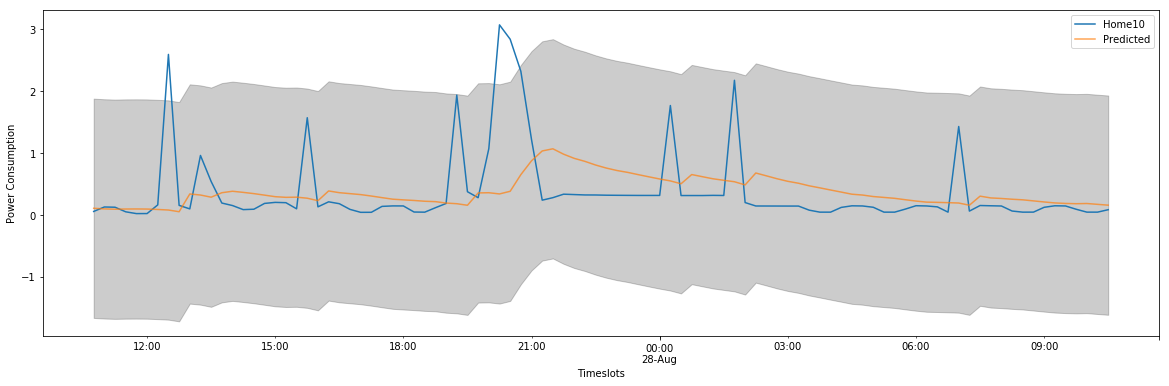

In [653]:
#Forecast:
pred = results.get_prediction(start=pred_timeslot, end=end_of_next_day, dynamic=False)
pred_ci = pred.conf_int()

#Plot:
ax = data[pred_timeslot:end_of_next_day].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Timeslots')
ax.set_ylabel('Power Consumption')
plt.legend()
plt.show()

### 6.5: Get MAE Error 

In [654]:
df_predicted = pred.predicted_mean
df_actual = data[pred_timeslot:end_of_next_day][home]
print("Mean absolute error LR: %.9f kW" % mean_absolute_error(df_actual, df_predicted))

Mean absolute error LR: 0.388920689 kW
